<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Photo_Realistic_Single_Image_Super_Resolution_Using_a_Generative_Adversarial_Network_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network**

논문 링크: https://arxiv.org/abs/1609.04802

해당 논문은 최초로 4x upscaling이 가능한 논문이다. 기존 논문들을 통해 SISR 분야의 정확성 문제와 속도 문제가 많이 개선 되었으나, perceptual texture detail이 부족하여 이를 해결하기 위해 고안된 논문이다.

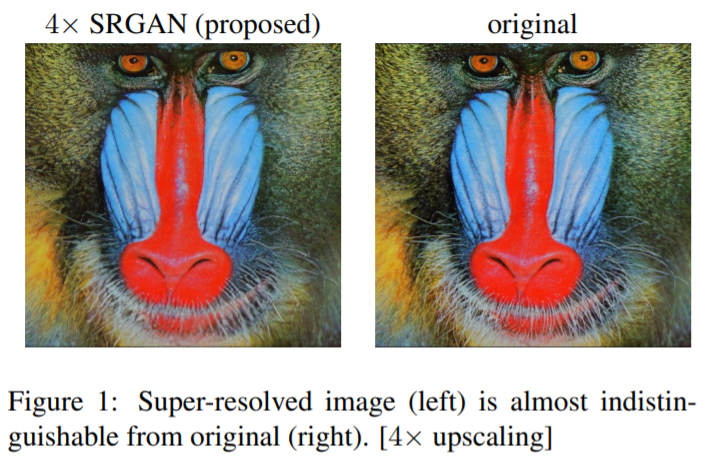

위의 그림 Figure 1은 SRGAN의 성능을 보여준다. 4x upscaling을 한 것이며, 원본 이미지와 매우 유사한 것을 확인할 수 있다.

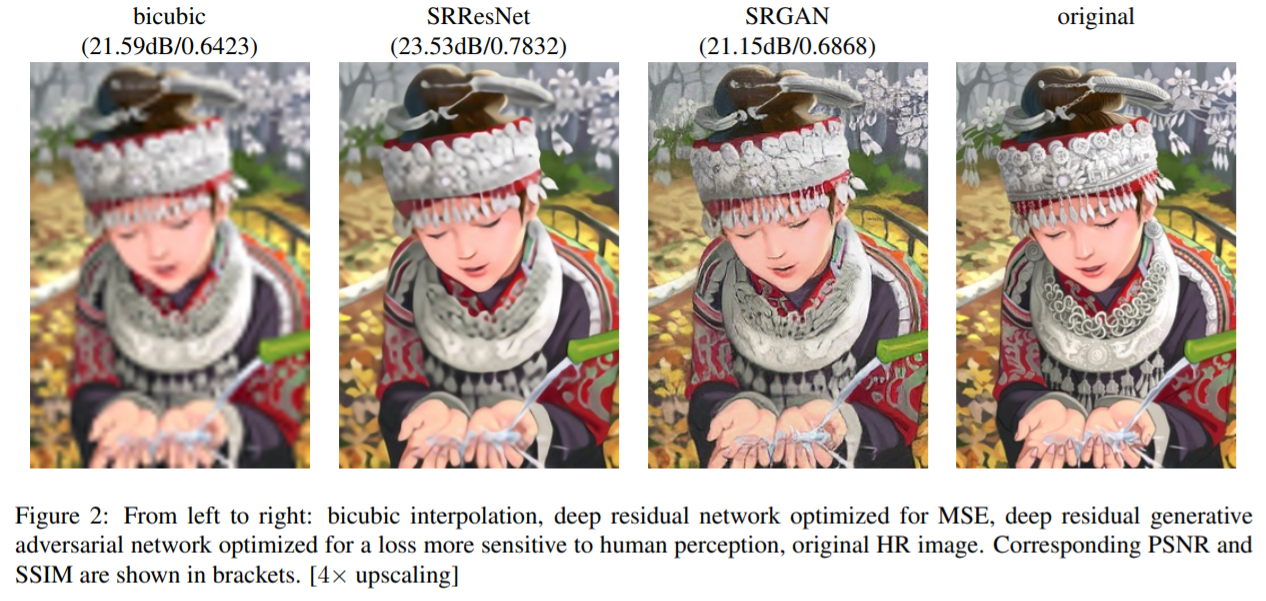

SISR 분야의 기존 방식은 MSE를 줄여 PSNR을 키우는 것이다. 하지만 본 논문에서는 **PSNR이 pixel-wise 기반이기 때문에 perceptually relevant 표현을 잘하지 못하는 한계를 가지고 있다**고 주장한다. 따라서 GAN과 perceptual loss function을 이용해 이를 해결하는 SRGAN을 제안하게 되었다.

실제로 위의 그림 Figure 2를 보면 bicubic과 SRResNet이 SRGAN보다 PSNR이 높지만 사람의 눈으로 판단했을때 SRGAN이 bicubic보다 훨씬 우수하다. 또한 SRResNet 같은 경우 뒤의 background가 흐릿한걸 볼 수 있는데, SRGAN은 훨씬 선명한 것을 볼 수 있다. 즉, texture detail에서 SRGAN이 더욱 좋다는 것이다. 따라서 PSNR이 더 나은 SR 결과를 반드시 보장하는 것이 아님을 알 수 있다.

## **SRGAN 구조**

본 논문에서는 두가지 모델을 제안했는데, 바로 skip-connection과 MSE로 나뉘는 ResNet 구조와 새롭게 정의한 perceptual loss를 이용한 SRGAN이다. 이를 통해 4x upsacling factor를 가지는 super-resolved photo-realistic image를 생성하는 것이 목표이다.

### **Architecture**

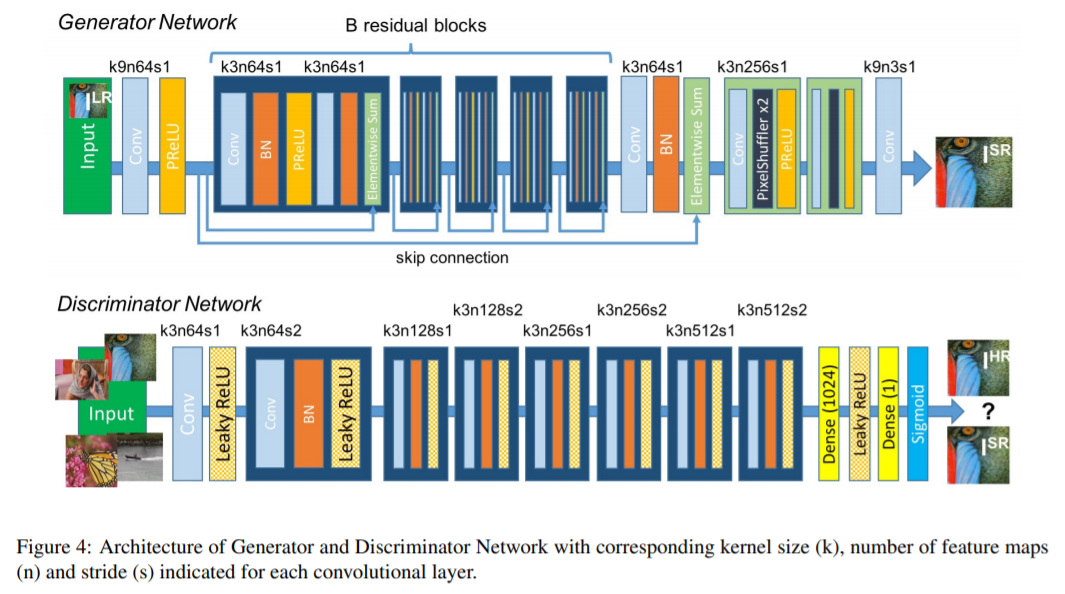

위의 그림 Figure 4를 보면 SRGAN의 구조를 알 수 있다. SRGAN의 generator(SRResNet)은 skip-connection을 활용하였으며 PReLU를 사용하였다. 또한 Resolution을 증가시키기 위하여 sub-pixel convolution layer를 사용했다. 그리고 discriminator의 경우는 Leaky ReLU를 사용했고 마지막은 sigmoid function을 사용했다. (sub-pixel convolution layer의 경우 해당 논문(https://arxiv.org/abs/1609.05158)을 참고하면 된다.)

#### **Pytorch**

In [1]:
import torch
import torch.nn as nn

# SRGAN Generator = SRResNet
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, nker=64, norm='bnorm', nblock=16):
        super(Generator, self).__init__()

        # Linear vector (100,)과 matrix (100, 1, 1)의 정보량은 동일
        self.enc = CBR2d(in_channels, nker, kernel_size=9, stride=1, padding=4, norm=None, relu='prelu', bias=True)
        
        resblocks = []

        for i in range(nblock):
            res += [ResBlock(nker, nker, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu='prelu')]

        self.res = nn.Sequential(*resblocks)

        self.dec = CBR2d(nker, nker, kernel_size=3, stride=1, padding=1, bias=True, norm=norm, relu=None)

        ps1 = []
        ps1 += [nn.Conv2d(in_channels=nker, out_channels=4 * nker, kernel_size=3, stride=1, padding=1)]
        ps1 += [PixelShuffle(ry=2, rx=2)]
        ps1 += [nn.PReLU]
        self.ps1 = nn.Sequential(*ps1)

        ps2 = []
        ps2 += [nn.Conv2d(in_channels=nker, out_channels=4 * nker, kernel_size=3, stride=1, padding=1)]
        ps2 += [PixelShuffle(ry=2, rx=2)]
        ps2 += [nn.PReLU()]
        self.ps2 = nn.Sequential(*ps2)

        self.fc = CBR2d(nker, out_channels, kernel_size=9, stride=1, padding=4, bias=True, norm=None, relu=None)


    def forward(self, x):
        x = self.enc(x)
        identity = x

        x = self.res(x)

        x = self.dec(x)

        x = x + identity
        x = self.ps1(x)
        x = self.ps2(x)

        x = self.fc(x)

        return x
        

# SRGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels, out_channels, nker=64, norm='bnorm'):
        super(Discriminator, self).__init__()

        discriminatorblocks = []

        for i, nker in enumerate([64, 128, 256, 512]):
            discriminatorblocks += [DiscriminatorBlock(in_channels, nker, first_block=(i == 0))]
            in_channels = nker

        self.discriminatorblocks = nn.Sequential(*discriminatorblocks)
        
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(nker, 2 * nker, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * nker, out_channels, kernel_size=1)
        )

        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        x = self.discriminatorblocks(x)
        
        x = self.fc(x)

        return self.sig(x.view(batch_size))


class PixelShuffle(nn.Module):
    def __init__(self, ry=2, rx=2):
        super().__init__()
        self.ry = ry
        self.rx = rx

    def forward(self, x):
        ry = self.ry
        rx = self.rx

        [B, C, H, W] = list(x.shape)

        x = x.reshape(B, C // (ry * rx), ry, rx, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // (ry * rx), H * ry, W * rx)

        return x

class PixelUnshuffle(nn.Module):
    def __init__(self, ry=2, rx=2):
        super().__init__()
        self.ry = ry
        self.rx = rx

    def forward(self, x):
        ry = self.ry
        rx = self.rx

        [B, C, H, W] = list(x.shape)

        x = x.reshape(B, C, H // ry, ry, W // rx, rx)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * (ry * rx), H // ry, W // rx)

        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm='bnorm', relu=0.0):
        super().__init__()

        layers = []

        layers += [CBR2d(in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, bias=bias, norm=norm, relu=relu)]
        
        layers += [CBR2d(in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, bias=bias, norm=norm, relu=None)]

        self.resblock = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.resblock(x)


class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm='bnorm', relu=0.0, first_block=False):
        super().__init__()

        layers = []

        layers += [CBR2d(in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, bias=bias, norm=None, relu=None)]
        if not first_block:
                layers += [nn.BatchNorm2d(num_features=out_channels)]
        layers += [nn.LeakyReLU(0.2, inplace=True)]
        
        layers += [CBR2d(in_channels, out_channels, kernel_size=kernel_size,
                stride=2, padding=padding, bias=bias, norm=norm, relu=0.2)]

        self.discriminatorblock = nn.Sequential(*layers)

    def forward(self, x):
        return self.discriminatorblock(x)



class CBR2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, norm='bnorm', relu=0.0):
        super().__init__()

        layers = []
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                    kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]

        if not norm is None:
            if norm == 'bnorm':
                layers += [nn.BatchNorm2d(num_features=out_channels)]
            elif norm == 'inorm':
                layers += [nn.InstanceNorm2d(num_features=out_channels)]

        if relu == 'prelu':
            layers += [nn.PReLU]
        elif not relu is None and relu >= 0.0:
            layers += [nn.ReLU() if relu == 0 else nn.LeakyReLU(relu)]

        self.cbr = nn.Sequential(*layers)

    def forward(self, x):
        return self.cbr(x)

위의 코드는 SRGAN를 pytorch로 구현한 코드이다.

### **Loss function**

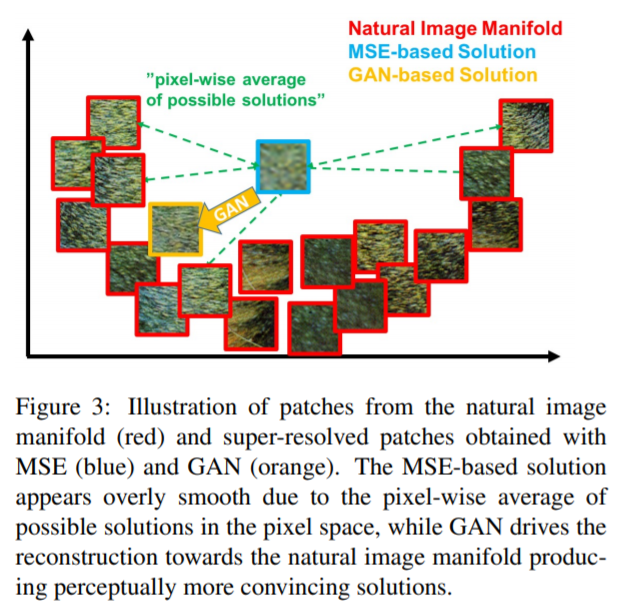

먼저 위에서 살펴본 것과 같이 기존 MSE와 같은 Pixel-wise loss function들은 texture와 같은 high frequency detail이 잘 살아있는 multi potential solution들을 잃어버린채 복원하는 불확실성을 가지고 있다. 이로 인해 본 논문에서는 해결책으로 GAN과 perceptual loss function을 제안했다. GAN의 경우 natural image maniford에서 재구성된 이미지를 복원하기 때문에 보다 perpetually(지각적으로) 설득력 있는 방법이다. 또한 원본 이미지와 GAN이 생성한 이미지를 구분하는 adversarial loss와 pixel space의 similary 대신 perceptual similarity를 학습하는 content loss를 포함하는 perceptual loss를 사용함으로써 문제를 해결했다.

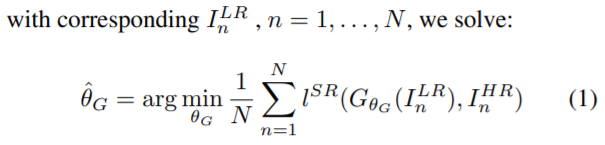

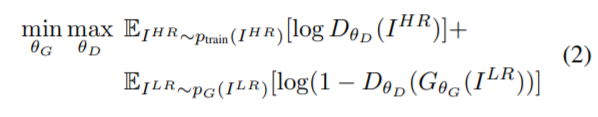

위의 loss function을 설명하기전 각 변수를 정리하자면,
- I^LR: low resolution image, input
- I^SR: super-resolved image, output
- I^HR: high resolution image, ground truth

(I^LR의 경ㅇ는 I^HR에 gaussian filter를 적용하여 얻는다.)

즉, 정리하자면 discriminator 입장에서 real 단계에서는 I^HR을 넣음으로써 discriminator가 real로 구분하게 하고, fake 단계에서는 generator가 I^LR 이미지를 통해 생성한 이미지를 discriminator가 fake로 구분해야한다. 반대로 generator의 입장에서는 I^LR를 통해 생성한 이미지를 discriminator가 real로 구분하게끔 만들어야한다.

#### **Perceptual loss function**

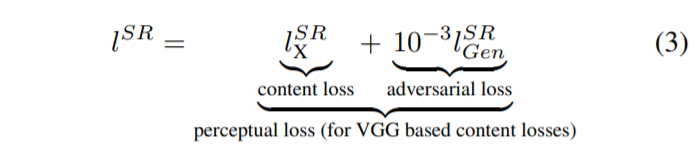

I^SR은 위와 같이 정의가 된다.

#### **Content loss**

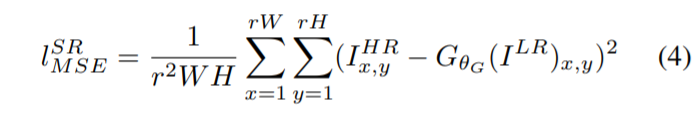

pixel-wise MSE loss는 위와 같이 정의가 된다.

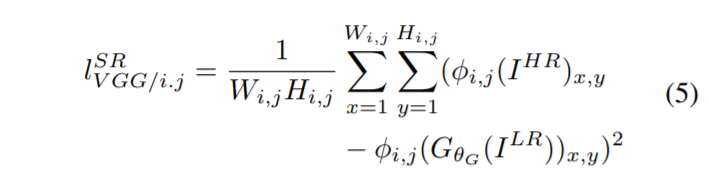

하지만 위에서 봤던 Figure 2와 같이 high PSNR을 얻더라도 무조건 좋은 것이 아니므로 pixel-wise loss 대신 위와 같이 pretrained된 VGG-19를 정의한다.

#### **Adversarial loss**

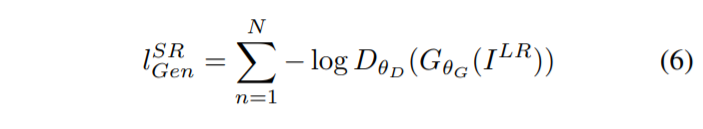

그리고 Adversarial loss는 위와 같이 정의가 되는데, GAN의 loss function을 알고 있다면 쉽게 이해할 수 있으므로 넘어가겠다.

## **Experiments**

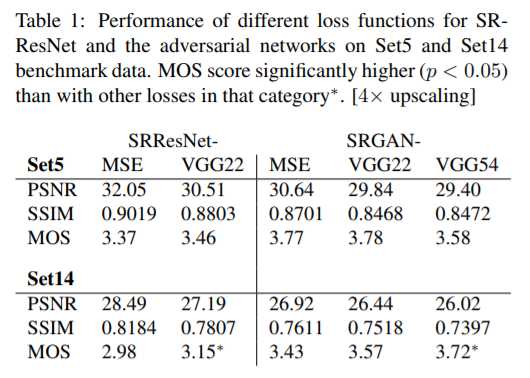

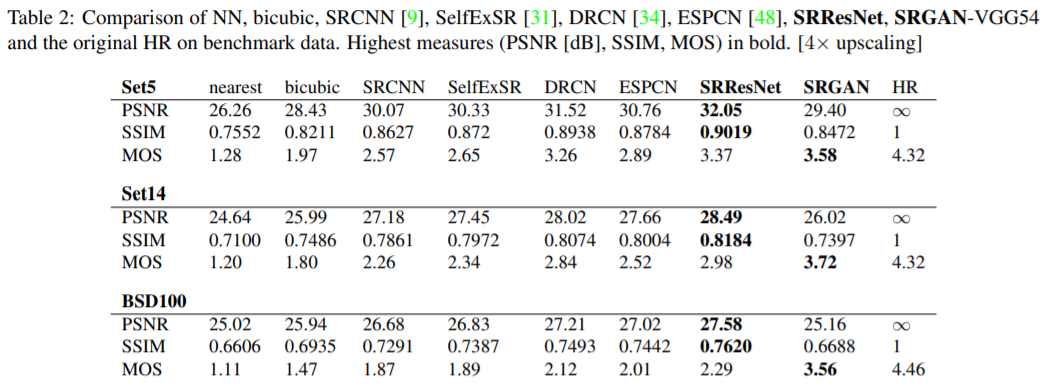

위의 표 Table 1과 Table 2에서는 여러 모델들의 PSNR, SSIM, MOS 값을 비교한 것이다. SRResNet이 PSNR과 SSIM에서 좋은 모습을 보여주며, SRGAN은 MOS에서 좋은 모습을 보여준다.

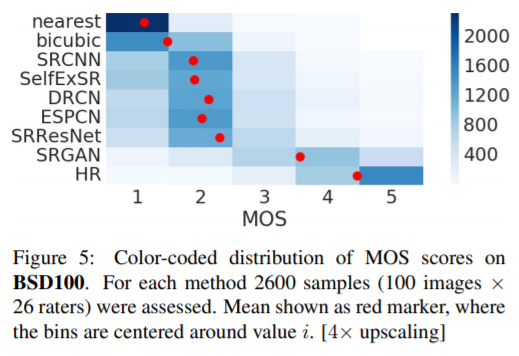

위의 그림 Figure 5는 여러 모델의 MOS score를 비교한 것인데, 다른 모델에 비해 SRGAN이 원본 이미지인 HR의 MOS score와 상당히 가까운 것을 알 수 있다.

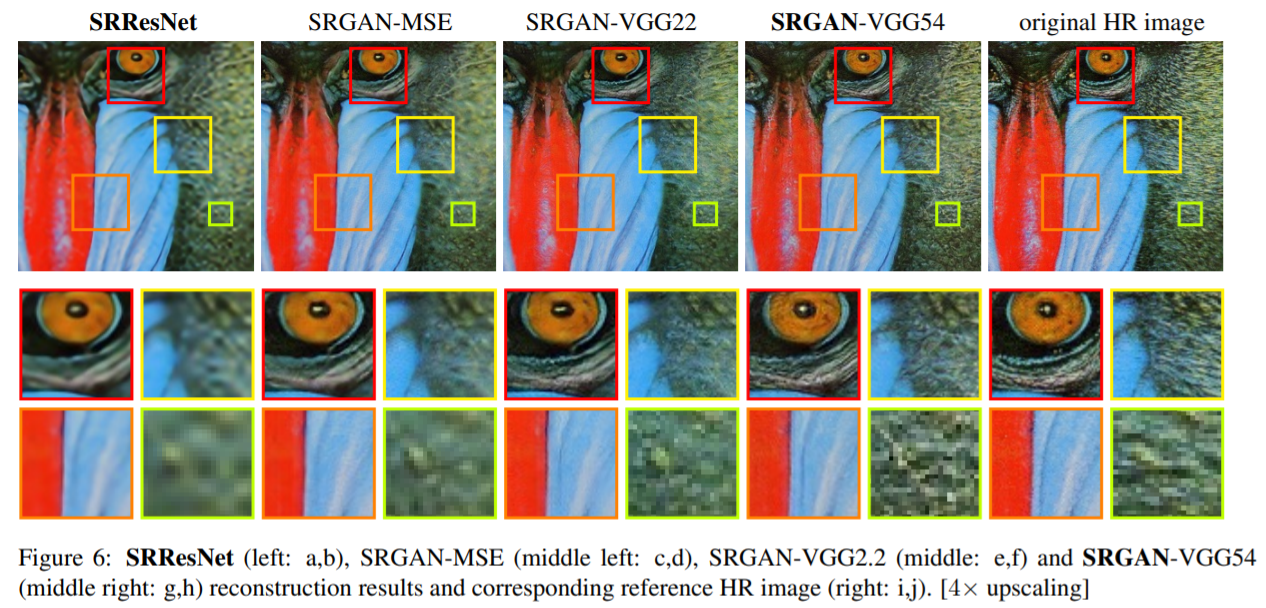

위의 그림 Figure 6은 실제 모델의 output들을 비교한 것인데, SRGAN-VGG54가 original HR image와 매우 유사한 것을 알 수 있다.

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('https://www.youtube.com/watch?time_continue=15&v=sUhbIdSd6dc&feature=emb_title', width=600, height=480)

마지막으로 Interstellar에 SRGAN을 적용시킨 영상이 있어 가져와봤다.